# 全卷积网络
:label:`sec_fcn`

如 :numref:`sec_semantic_segmentation`中所介绍的那样，语义分割是对图像中的每个像素分类。
*全卷积网络*（fully convolutional network，FCN）采用卷积神经网络实现了从图像像素到像素类别的变换 :cite:`Long.Shelhamer.Darrell.2015`。
与我们之前在图像分类或目标检测部分介绍的卷积神经网络不同，全卷积网络将中间层特征图的高和宽变换回输入图像的尺寸：这是通过在 :numref:`sec_transposed_conv`中引入的*转置卷积*（transposed convolution）实现的。
因此，输出的类别预测与输入图像在像素级别上具有一一对应关系：通道维的输出即该位置对应像素的类别预测。


In [31]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## 构造模型

下面我们了解一下全卷积网络模型最基本的设计。
如 :numref:`fig_fcn`所示，全卷积网络先使用卷积神经网络抽取图像特征，然后通过$1\times 1$卷积层将通道数变换为类别个数，最后在 :numref:`sec_transposed_conv`中通过转置卷积层将特征图的高和宽变换为输入图像的尺寸。
因此，模型输出与输入图像的高和宽相同，且最终输出通道包含了该空间位置像素的类别预测。

![全卷积网络](../img/fcn.svg)
:label:`fig_fcn`

下面，我们[**使用在ImageNet数据集上预训练的ResNet-18模型来提取图像特征**]，并将该网络记为`pretrained_net`。
ResNet-18模型的最后几层包括全局平均汇聚层和全连接层，然而全卷积网络中不需要它们。


In [32]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
# ajee: [-3:] returns the last 3 layers of the model
list(pretrained_net.children())[-3:]

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

接下来，我们[**创建一个全卷积网络`net`**]。
它复制了ResNet-18中大部分的预训练层，除了最后的全局平均汇聚层和最接近输出的全连接层。


In [33]:
net = nn.Sequential(*list(pretrained_net.children())[:-2])

给定高度为320和宽度为480的输入，`net`的前向传播将输入的高和宽减小至原来的$1/32$，即10和15。


In [34]:
X = torch.rand(size=(1, 3, 320, 480))
net(X).shape

torch.Size([1, 512, 10, 15])

接下来[**使用$1\times1$卷积层将输出通道数转换为Pascal VOC2012数据集的类数（21类）。**]
最后需要(**将特征图的高度和宽度增加32倍**)，从而将其变回输入图像的高和宽。
回想一下 :numref:`sec_padding`中卷积层输出形状的计算方法：
由于$(320-64+16\times2+32)/32=10$且$(480-64+16\times2+32)/32=15$，我们构造一个步幅为$32$的转置卷积层，并将卷积核的高和宽设为$64$，填充为$16$。
我们可以看到如果步幅为$s$，填充为$s/2$（假设$s/2$是整数）且卷积核的高和宽为$2s$，转置卷积核会将输入的高和宽分别放大$s$倍。


In [35]:
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes,
                                    kernel_size=64, padding=16, stride=32))
# ajee： net的输出形状是(batch_size, num_classes, 320, 480)，转置卷积是扩图但是维度没有变化

## [**初始化转置卷积层**]

在图像处理中，我们有时需要将图像放大，即*上采样*（upsampling）。
*双线性插值*（bilinear interpolation）
是常用的上采样方法之一，它也经常用于初始化转置卷积层。

为了解释双线性插值，假设给定输入图像，我们想要计算上采样输出图像上的每个像素。

1. 将输出图像的坐标$(x,y)$映射到输入图像的坐标$(x',y')$上。
例如，根据输入与输出的尺寸之比来映射。
请注意，映射后的$x′$和$y′$是实数。
2. 在输入图像上找到离坐标$(x',y')$最近的4个像素。
3. 输出图像在坐标$(x,y)$上的像素依据输入图像上这4个像素及其与$(x',y')$的相对距离来计算。

双线性插值的上采样可以通过转置卷积层实现，内核由以下`bilinear_kernel`函数构造。
限于篇幅，我们只给出`bilinear_kernel`函数的实现，不讨论算法的原理。


In [36]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

让我们用[**双线性插值的上采样实验**]它由转置卷积层实现。
我们构造一个将输入的高和宽放大2倍的转置卷积层，并将其卷积核用`bilinear_kernel`函数初始化。


In [37]:
stride = 2
padding = stride//2
kernel_size = stride * 2
print(f'kernel_size: {kernel_size}, padding: {padding}, stride: {stride}')
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size = kernel_size , padding = padding , stride = stride,
                                bias=False)
# b_kernel = bilinear_kernel(3, 3, kernel_size) # ajee: b_kernel shape: (3, 3, 20, 20)
# b_kernel = torch.rand((3, 3, kernel_size, kernel_size))
# print(f'b_kernel.shape: {b_kernel.shape}')
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, kernel_size));

kernel_size: 4, padding: 1, stride: 2


In [38]:
# conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2,
#                                 bias=False)
# conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4));

读取图像`X`，将上采样的结果记作`Y`。为了打印图像，我们需要调整通道维的位置。


In [39]:
img = torchvision.transforms.ToTensor()(d2l.Image.open('../img/catdog.jpg'))
print(f'img.shape: {img.shape}')
X = img.unsqueeze(0)
Y = conv_trans(X)
print(f'Y.shape: {Y.shape}')
out_img = Y[0].permute(1, 2, 0).detach()

img.shape: torch.Size([3, 561, 728])
Y.shape: torch.Size([1, 3, 1122, 1456])


可以看到，转置卷积层将图像的高和宽分别放大了2倍。
除了坐标刻度不同，双线性插值放大的图像和在 :numref:`sec_bbox`中打印出的原图看上去没什么两样。


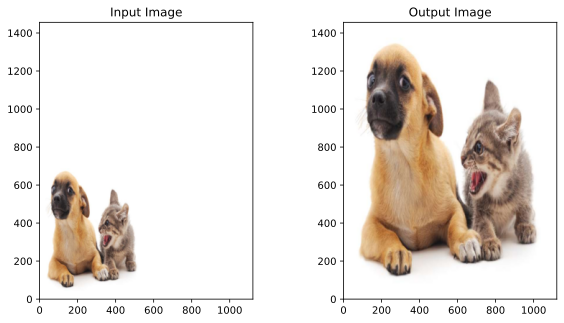

In [40]:
d2l.set_figsize()
# print('input image shape:', img.permute(1, 2, 0).shape)
# d2l.plt.imshow(img.permute(1, 2, 0))
# print('output image shape:', out_img.shape)
# d2l.plt.imshow(out_img)

# 创建子图并列显示
fig, axes = d2l.plt.subplots(1, 2, figsize=(10, 5))  # 1行2列的子图
img_new = img.permute(1, 2, 0)
input_w , input_h = img_new.shape[0], img_new.shape[1]
output_w , output_h = out_img.shape[0], out_img.shape[1]
max_w_axes = max(input_w, output_w)
max_h_axes = max(input_h, output_h)
# 显示输入图片，设置坐标范围
axes[0].imshow(img_new, extent=[0, input_w, 0, input_h])
axes[0].set_title("Input Image")
axes[0].set_xlim(0, max_w_axes)
axes[0].set_ylim(0, max_h_axes)

# 显示输出图片，设置坐标范围
axes[1].imshow(out_img, extent=[0, output_w, 0, output_h])
axes[1].set_title("Output Image")
axes[1].set_xlim(0, max_w_axes)
axes[1].set_ylim(0, max_h_axes)



d2l.plt.show()

全卷积网络[**用双线性插值的上采样初始化转置卷积层。对于$1\times 1$卷积层，我们使用Xavier初始化参数。**]


In [41]:
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W);

## [**读取数据集**]

我们用 :numref:`sec_semantic_segmentation`中介绍的语义分割读取数据集。
指定随机裁剪的输出图像的形状为$320\times 480$：高和宽都可以被$32$整除。


In [42]:
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples
read 1078 examples


In [ ]:
import matplotlib.pyplot as plt

# 从 train_iter 中取出一个批次
for X, y in train_iter:
    # 遍历批次中的每张图片及其对应的标签
    for i in range(X.shape[0]):
        img = X[i].permute(1, 2, 0).numpy()  # 转换为 (H, W, C) 格式
        label = y[i].numpy()  # 标签通常是 (H, W) 格式
        
        # 创建一个图形窗口
        plt.figure(figsize=(10, 5))
        
        # 显示图片
        plt.subplot(1, 2, 1)
        plt.imshow((img - img.min()) / (img.max() - img.min()))  # 归一化到 [0, 1] 范围
        plt.axis('off')
        plt.title("Cropped Image")
        
        # 显示对应的标签
        plt.subplot(1, 2, 2)
        plt.imshow(label, cmap='gray')  # 标签用灰度图显示
        plt.axis('off')
        plt.title("Segmentation Label")
        
        plt.show()
    
    break  # 只显示一个批次

## [**训练**]

现在我们可以训练全卷积网络了。
这里的损失函数和准确率计算与图像分类中的并没有本质上的不同，因为我们使用转置卷积层的通道来预测像素的类别，所以需要在损失计算中指定通道维。
此外，模型基于每个像素的预测类别是否正确来计算准确率。


In [ ]:
# ajee： inputs 是模型net的输出，形状为 (batch_size, num_classes, height, width)。
# 这里的 num_classes 是类别数，表示每个像素属于不同类别的概率分布logits。
# targets 的形状:
#   targets 是标签，形状为 (batch_size, height, width)。
#   它是每个像素的类别索引（整数值），不包含通道维。
# F.cross_entropy 的作用:
#   F.cross_entropy 会自动将 inputs 的通道维（num_classes）作为类别维度进行处理。
#   换句话说，F.cross_entropy 会在 inputs 的第二个维度（通道维）上计算每个像素的交叉熵损失。
# cross_entropy的输出形状是 (batch_size, height, width)，每个点代表每个像素的损失（见交叉熵的计算过程）。
# mean(1).mean(1) 的作用:
#    mean(1)：对高度维度（height）求平均。
#   再次 mean(1)：对宽度维度（width）求平均。
#   最终结果是对每张图片的所有像素的损失值求平均，得到一个形状为 (batch_size,) 的张量。
#   在train_batch_ch13里面，做l.sum()进行聚合为标量。如果不是train_batch_ch13里面的聚合，也可以在这里再加一个mean(1)。
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

## [**预测**]

在预测时，我们需要将输入图像在各个通道做标准化，并转成卷积神经网络所需要的四维输入格式。


In [ ]:
def predict(img):
    # ajee：按照test dataset来归一化
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    # ajee: net输出形状为(batch_size, num_classes, height, width)，所以取第一维的最大值的索引为预测类，形状为(height, width)
    pred = net(X.to(devices[0])).argmax(dim=1)
    # ajee: 弄成(height, width)的形状
    return pred.reshape(pred.shape[1], pred.shape[2])

为了[**可视化预测的类别**]给每个像素，我们将预测类别映射回它们在数据集中的标注颜色。


In [ ]:
def label2image(pred):
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]

测试数据集中的图像大小和形状各异。
由于模型使用了步幅为32的转置卷积层，因此当输入图像的高或宽无法被32整除时，转置卷积层输出的高或宽会与输入图像的尺寸有偏差。
为了解决这个问题，我们可以在图像中截取多块高和宽为32的整数倍的矩形区域，并分别对这些区域中的像素做前向传播。
请注意，这些区域的并集需要完整覆盖输入图像。
当一个像素被多个区域所覆盖时，它在不同区域前向传播中转置卷积层输出的平均值可以作为`softmax`运算的输入，从而预测类别。

为简单起见，我们只读取几张较大的测试图像，并从图像的左上角开始截取形状为$320\times480$的区域用于预测。
对于这些测试图像，我们逐一打印它们截取的区域，再打印预测结果，最后打印标注的类别。


In [ ]:
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X.permute(1,2,0), pred.cpu(),
             torchvision.transforms.functional.crop(
                 test_labels[i], *crop_rect).permute(1,2,0)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);

## 小结

* 全卷积网络先使用卷积神经网络抽取图像特征，然后通过$1\times 1$卷积层将通道数变换为类别个数，最后通过转置卷积层将特征图的高和宽变换为输入图像的尺寸。
* 在全卷积网络中，我们可以将转置卷积层初始化为双线性插值的上采样。

## 练习

1. 如果将转置卷积层改用Xavier随机初始化，结果有什么变化？
1. 调节超参数，能进一步提升模型的精度吗？
1. 预测测试图像中所有像素的类别。
1. 最初的全卷积网络的论文中 :cite:`Long.Shelhamer.Darrell.2015`还使用了某些卷积神经网络中间层的输出。试着实现这个想法。


[Discussions](https://discuss.d2l.ai/t/3297)
